In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns

In [3]:
df = pd.read_csv("CPIAUCSL.csv")

df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)
df.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)

df = df[df.index >= '2000-01-01']

df.head()

,CPI
observation_date,
2000-01-01,169.3
2000-02-01,170.0
2000-03-01,171.0
2000-04-01,170.9
2000-05-01,171.2


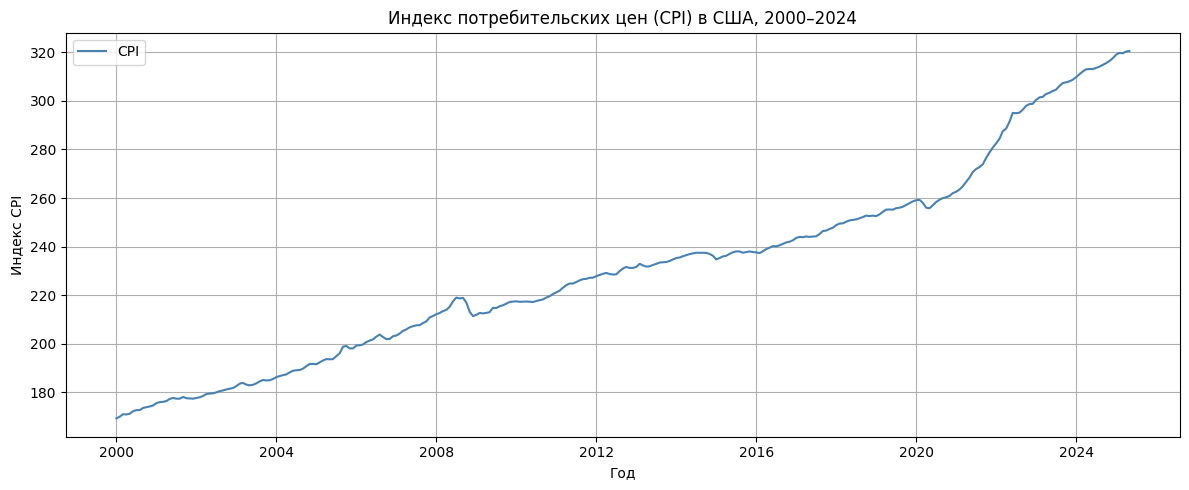

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['CPI'], label='CPI', color='steelblue')
plt.title('Индекс потребительских цен (CPI) в США, 2000–2024')
plt.xlabel('Год')
plt.ylabel('Индекс CPI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

На графике
- устойчивый рост CPI — инфляционный тренд

- нет резких скачков (ряд «гладкий»)

- возможны изменения темпа роста в кризисные/посткризисные периоды

### Проверка стационарности

In [6]:
# ADF-тест
adf_result = adfuller(df['CPI'])

adf_summary = {
    'ADF statistic': adf_result[0],
    'p-value': adf_result[1],
    'Used lags': adf_result[2],
    'Number of observations': adf_result[3]
}
adf_summary.update({f'Critical Value ({k})': v for k, v in adf_result[4].items()})

pd.DataFrame(adf_summary, index=["ADF Test (уровневый ряд)"])

,ADF statistic,p-value,Used lags,Number of observations,Critical Value (1%),Critical Value (5%),Critical Value (10%)
ADF Test (уровневый ряд),1.072593,0.994976,15,289,-3.453182,-2.871593,-2.572127


Результаты ADF-теста (на уровне):

ADF statistic = 1.07

p-value ≈ 0.995

Критические значения: -3.45 (1%), -2.87 (5%), -2.57 (10%)

Вывод: ряд нестационарен (p-value ≫ 0.05) — подтверждает наличие тренда.

#### Первое дифференцирование

In [7]:
df_diff = df.diff().dropna()

# ADF-тест на дифференцированном ряду
adf_diff_result = adfuller(df_diff['CPI'])

adf_diff_summary = {
    'ADF statistic': adf_diff_result[0],
    'p-value': adf_diff_result[1],
    'Used lags': adf_diff_result[2],
    'Number of observations': adf_diff_result[3]
}
adf_diff_summary.update({f'Critical Value ({k})': v for k, v in adf_diff_result[4].items()})

pd.DataFrame(adf_diff_summary, index=["ADF Test (1-я разность)"])

,ADF statistic,p-value,Used lags,Number of observations,Critical Value (1%),Critical Value (5%),Critical Value (10%)
ADF Test (1-я разность),-2.695769,0.074773,14,289,-3.453182,-2.871593,-2.572127


Результаты ADF-теста после первого дифференцирования:

ADF statistic = -2.70

p-value ≈ 0.075

Критические значения:

1%: -3.45

5%: -2.87

10%: -2.57

Вывод:
Ряд почти стационарен — статистика чуть ниже критической на уровне 10%. Можно считать его слабой стационарностью, допустимой для ARIMA-моделирования.

### Построение модели ARIMA
#### Анализ автокорреляций

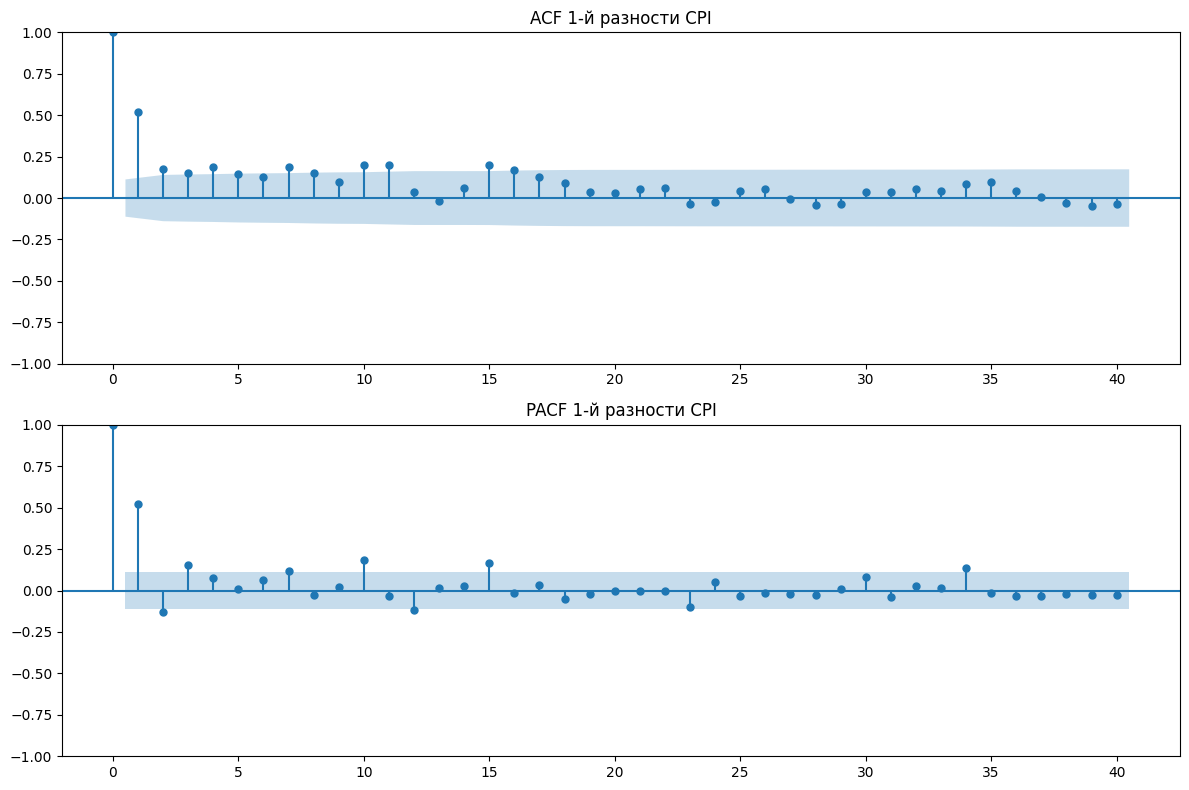

In [9]:
# ACF и PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff['CPI'], ax=ax[0], lags=40)
plot_pacf(df_diff['CPI'], ax=ax[1], lags=40, method='ywm')
ax[0].set_title('ACF 1-й разности CPI')
ax[1].set_title('PACF 1-й разности CPI')
plt.tight_layout()
plt.show()

Из графиков:

ACF медленно затухает — возможен компонент MA.

PACF резко обрывается после лага 1 — возможен AR(1).

Предварительное предположение: ARIMA(1,1,1) — разумный выбор.

In [ ]:
# Модель ARIMA(1,1,1)
model = ARIMA(df['CPI'], order=(1, 1, 1))
result = model.fit()

result.summary()

/Users/k.chervaneva/Desktop/мфти учеба/Econometric/second_sem/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/k.chervaneva/Desktop/мфти учеба/Econometric/second_sem/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/k.chervaneva/Desktop/мфти учеба/Econometric/second_sem/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  305
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -299.823
Date:                Fri, 13 Jun 2025   AIC                            605.646
Time:                        17:51:54   BIC                            616.797
Sample:                    01-01-2000   HQIC                           610.107
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6077      0.044     13.916      0.000       0.522       0.693
ma.L1          0.1162      0.059      1.959      0.050   -6.35e-05       0.232
sigma2         0.4200      0.024     17.295      0.000       0.372       0.468
===================================================================================
Ljung-Box (L1) (Q):                   2.63   Jarque-Bera (JB):               126.99
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                            -0.55
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Итоги модели ARIMA(1,1,1):

AR(1) = 0.61, значим (p < 0.001)

MA(1) = 0.12, на границе значимости (p ≈ 0.050)

σ² (ошибка) = 0.42, небольшая дисперсия

Метрики:

AIC = 605.6 — хорошее качество

JB тест = 126.99, p = 0.00 — остатки не совсем нормально распределены (возможно, асимметрия)

Ljung-Box (Q) = 2.63, p ≈ 0.10 — автокорреляция остатков отсутствует

Вывод: модель ARIMA(1,1,1) — адекватна и хорошо описывает поведение CPI

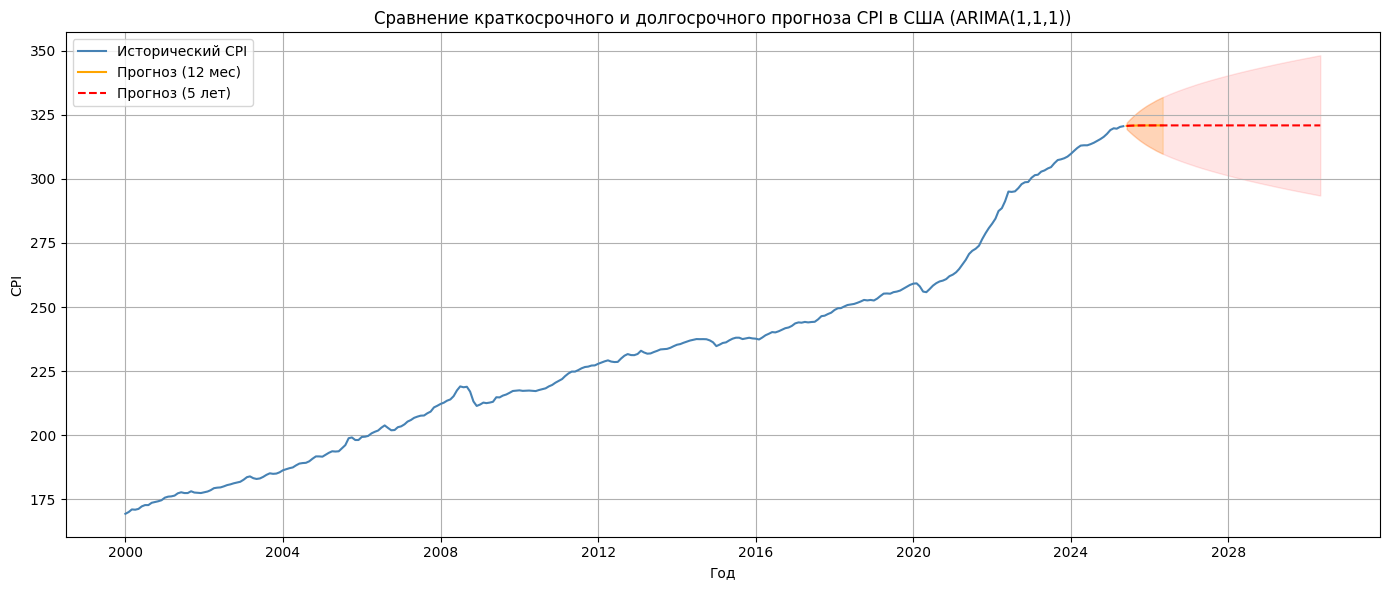

In [ ]:
# Прогноз на 12 месяцев
forecast_12m = result.get_forecast(steps=12)
forecast_12m_ci = forecast_12m.conf_int()
forecast_12m_index = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')
forecast_12m_mean = forecast_12m.predicted_mean.astype(float).values
lower_12m = forecast_12m_ci.iloc[:, 0].astype(float).values
upper_12m = forecast_12m_ci.iloc[:, 1].astype(float).values

# Прогноз на 60 месяцев
forecast_5y = result.get_forecast(steps=60)
forecast_5y_ci = forecast_5y.conf_int()
forecast_5y_index = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(), periods=60, freq='MS')
forecast_5y_mean = forecast_5y.predicted_mean.astype(float).values
lower_5y = forecast_5y_ci.iloc[:, 0].astype(float).values
upper_5y = forecast_5y_ci.iloc[:, 1].astype(float).values

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['CPI'], label='Исторический CPI', color='steelblue')
plt.plot(forecast_12m_index, forecast_12m_mean, label='Прогноз (12 мес)', color='orange')
plt.fill_between(forecast_12m_index, lower_12m, upper_12m, color='orange', alpha=0.2)

plt.plot(forecast_5y_index, forecast_5y_mean, label='Прогноз (5 лет)', color='red', linestyle='--')
plt.fill_between(forecast_5y_index, lower_5y, upper_5y, color='red', alpha=0.1)

plt.title('Сравнение краткосрочного и долгосрочного прогноза CPI в США (ARIMA(1,1,1))')
plt.xlabel('Год')
plt.ylabel('CPI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/Users/k.chervaneva/Desktop/мфти учеба/Econometric/second_sem/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/k.chervaneva/Desktop/мфти учеба/Econometric/second_sem/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


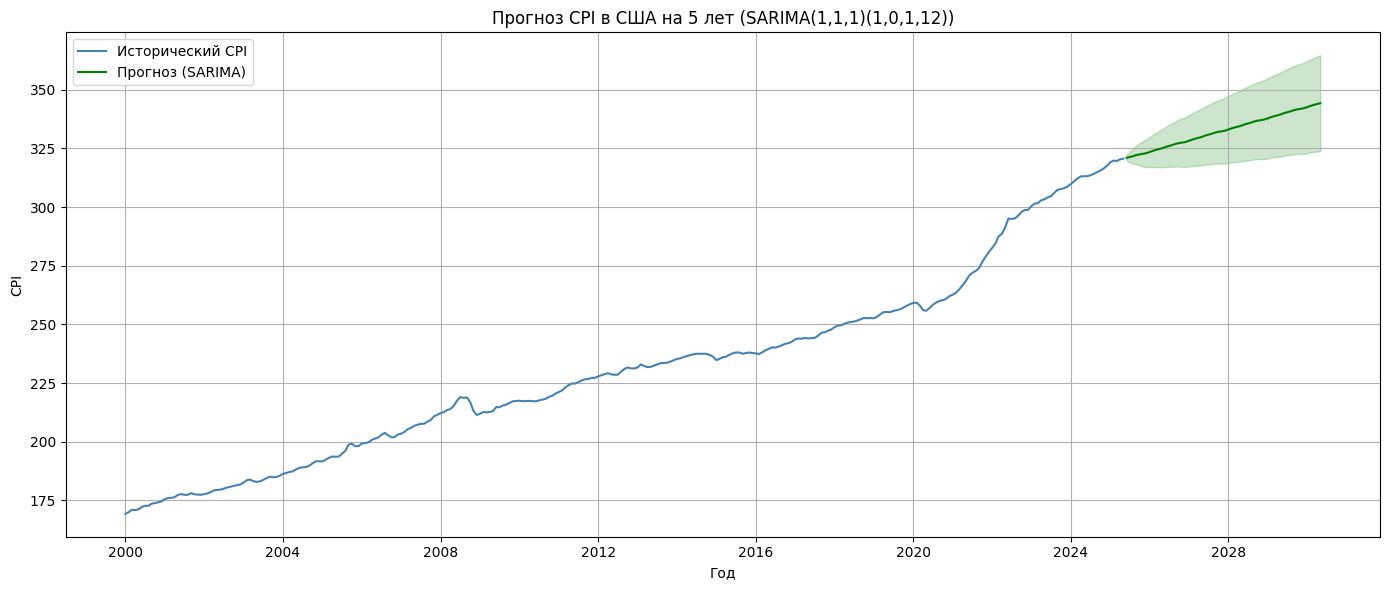

In [13]:
# Построим модель SARIMA: параметры на основе осмотра (1,1,1)(1,0,1,12)
sarima_model = SARIMAX(df['CPI'], order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# Прогноз на 60 месяцев
sarima_forecast = sarima_result.get_forecast(steps=60)
sarima_ci = sarima_forecast.conf_int()

# Индекс прогноза
sarima_index = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(), periods=60, freq='MS')
sarima_mean = sarima_forecast.predicted_mean.astype(float).values
sarima_lower = sarima_ci.iloc[:, 0].astype(float).values
sarima_upper = sarima_ci.iloc[:, 1].astype(float).values

# График SARIMA vs исторический CPI
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['CPI'], label='Исторический CPI', color='steelblue')
plt.plot(sarima_index, sarima_mean, label='Прогноз (SARIMA)', color='green')
plt.fill_between(sarima_index, sarima_lower, sarima_upper, color='green', alpha=0.2)
plt.title('Прогноз CPI в США на 5 лет (SARIMA(1,1,1)(1,0,1,12))')
plt.xlabel('Год')
plt.ylabel('CPI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Учтена сезонность с периодом 12 месяцев, поэтому траектория прогноза уже не линейная, а с характерными колебаниями (цикличность).

Затенённая область — доверительный интервал (95% CI), который также учитывает сезонную неопределённость.

### Вывод

CPI в США с 2000 года растёт стабильно и может быть моделирован с помощью ARIMA и SARIMA.

ARIMA хорошо описывает тренд, SARIMA — дополнительно учитывает сезонные эффекты.

Построенные прогнозы позволяют оценить ожидаемый уровень CPI на 1 и 5 лет вперёд, включая неопределённость.